In [75]:
from collections import Counter
import random

import numpy as np
import pyarrow.dataset as ds
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns

INDICADORES = {
    "AFD": "Adequação da Formação Docente",
    "ICG": "Complexidade de Gestão da Escola",
    "IED": "Esforço Docente",
    "ATU": "Média de Alunos por Turma",
    "HAD": "Média de Horas-aula diária",
    "DSU": "Percentual de Docentes com Curso Superior",
    "TDI": "Taxas de Distorção Idade-série"
}

DIMENSIONS = {
    "Ano": "NU_ANO_CENSO",
    "Nome da região geográfica": "NO_REGIAO",
    "Nome da Unidade da Federação": "NO_UF",
    "Nome da Mesorregião": "NO_MESORREGIAO",
    "Nome da Microrregião": "NO_MICRORREGIAO"
}

con = duckdb.connect('../../file.db')

microdados = ds.dataset("../../data/transformed/microdados.parquet", format="parquet", partitioning="hive")
con.register("microdados", microdados)

indicadores = {}
for indicador in INDICADORES:
    indicadores[indicador] = ds.dataset(f"../../data/transformed/indicadores/{indicador}.parquet", format="parquet", partitioning="hive")
    con.register(indicador, indicadores[indicador])

In [6]:
# quantidade de matriculas
dimension = "NU_ANO_CENSO"
quantidade_matriculas = con.execute(f"""
    select
        {dimension},
        cast(sum(QT_MAT_INF) as bigint) as 'Educação Básica',

        cast(sum(QT_MAT_FUND) as bigint) as 'Educação Infantil',
        cast(sum(QT_MAT_MED) as bigint) as 'Ensino Fundamental',
        cast(sum(QT_MAT_PROF) as bigint) as 'Ensino Médio',
        cast(sum(QT_MAT_PROF_TEC) as bigint) as 'Educação Profissional',
        cast(sum(QT_MAT_EJA) as bigint) as 'Educação de Jovens e Adultos (EJA)',
        cast(sum(QT_MAT_ESP) as bigint) as 'Educação Especial'
    from microdados
    group by {dimension}
    """
).df()
quantidade_matriculas.melt(
        id_vars=[dimension],
        var_name="Nível de ensino",
        value_name="Número de matriculas",
        value_vars=quantidade_matriculas.columns[1:]
     )

,NU_ANO_CENSO,Nível de ensino,Número de matriculas
0,2017,Educação Básica,8508731
1,2018,Educação Básica,8745184
2,2019,Educação Básica,8972778
3,2021,Educação Básica,8319399
4,2016,Educação Básica,8279104
5,2020,Educação Básica,8829795
6,2017,Educação Infantil,27348080
7,2018,Educação Infantil,27183970
8,2019,Educação Infantil,26923730
9,2021,Educação Infantil,26515601


In [4]:
# quantidade de escolas
dimension = "Ano"
quantidade_escolas = con.execute(f"""
    select
        {DIMENSIONS[dimension]} as {dimension},
        count(CO_ENTIDADE) as 'Quantidade de escolas'
    from microdados
    group by {DIMENSIONS[dimension]}
    """
).df()
quantidade_escolas

,Ano,Quantidade de escolas
0,2017,236481
1,2020,224229
2,2016,237506
3,2018,236460
4,2019,228521
5,2021,221140


In [32]:
dimension = "SG_UF"
indicador_grupo = "TDI"
tdi = con.execute(f"""
    select
        m.{dimension},
        i.GRUPO,
        i.METRICA
        from microdados m
        left join {indicador_grupo} i
            on m.NU_ANO_CENSO = i.NU_ANO_CENSO
            and m.CO_ENTIDADE = i.CO_ENTIDADE
        where i.GRUPO like '{indicador_grupo}%'
        --group by m.{dimension}, i.GRUPO
        --order by 2, 3 desc
    """
).df()
tdi

,SG_UF,GRUPO,METRICA
0,RO,TDI_F58,NaN
1,RO,TDI_F58,NaN
2,RO,TDI_F58,43.2
3,RO,TDI_F58,NaN
4,RO,TDI_F58,31.1
...,...,...,...
6995240,DF,TDI_FUN,16.7
6995241,DF,TDI_FUN,38.7
6995242,DF,TDI_FUN,18.4
6995243,DF,TDI_FUN,0.0


In [73]:
teste = tdi[(tdi.GRUPO == "TDI_FUN") & (tdi.SG_UF == "RO")]


<Axes: >

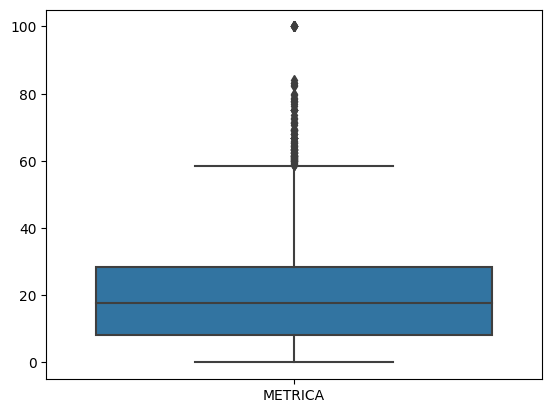

In [77]:
sns.boxplot(teste)

In [51]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3119 entries, 4207 to 4732957
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SG_UF    3119 non-null   object 
 1   GRUPO    3119 non-null   object 
 2   METRICA  3028 non-null   float64
dtypes: float64(1), object(2)
memory usage: 97.5+ KB


In [62]:
np.percentile(sorted(teste.METRICA), q=[0.6])

array([nan])

In [70]:
np.sort(teste.METRICA)[-100]

100.0

In [59]:
np.percentile(range(0, 100), q=5)

4.95

In [50]:
np.percentile?

In [31]:
dimension = "SG_UF"
indicador_grupo = "TDI"
tdi = con.execute(f"""
    select
        m.{dimension},
        i.GRUPO,
        PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY i.METRICA)
        from microdados m
        left join {indicador_grupo} i
            on m.NU_ANO_CENSO = i.NU_ANO_CENSO
            and m.CO_ENTIDADE = i.CO_ENTIDADE
        where i.GRUPO like '{indicador_grupo}%'
        group by m.{dimension}, i.GRUPO
        order by 2, 3 desc
    """
).df()
tdi

,SG_UF,GRUPO,"quantile_disc(0.5 ORDER BY i.""METRICA"")"
0,RJ,TDI_F00,3.8
1,CE,TDI_F00,0.0
2,SE,TDI_F00,0.0
3,ES,TDI_F00,0.0
4,SC,TDI_F00,0.0
...,...,...,...
454,GO,TDI_MED,21.4
455,PR,TDI_MED,20.5
456,SC,TDI_MED,18.4
457,DF,TDI_MED,13.1


In [29]:
tdi.groupby(["GRUPO", "SG_UF"]).describe()

METRICA                                                      
                 count       mean        std  min   25%   50%     75%    max
GRUPO   SG_UF                                                               
TDI_F00 AC      3388.0  13.243979  24.115818  0.0   0.0   0.0  16.700  100.0
        AL      6212.0   5.851433  11.703998  0.0   0.0   0.0   7.125  100.0
        AM     11782.0   7.645357  18.449596  0.0   0.0   0.0   4.400  100.0
        AP      1593.0   8.206277  15.622343  0.0   0.0   0.0  10.000  100.0
        BA     34196.0   5.867686  14.265594  0.0   0.0   0.0   5.600  100.0
...                ...        ...        ...  ...   ...   ...     ...    ...
TDI_MED RS      4483.0  28.306246  18.372103  0.0  13.1  27.7  40.050  100.0
        SC      2958.0  19.085700  12.825467  0.0   9.3  18.4  26.800   90.9
        SE       856.0  35.756075  21.571322  0.0  13.3  42.3  53.425   95.4
        SP     19177.0  10.832737   9.017993  0.0   4.0   8.9  15.600  100.0
        TO      1001.0  33.977423  20.177878  0.0  21.9  31.7  41.200  100.0

[459 rows x 8 columns]

In [27]:
tdi

,SG_UF,GRUPO,METRICA
0,BA,TDI_F00,NaN
1,GO,TDI_F00,NaN
2,BA,TDI_F00,NaN
3,BA,TDI_F00,NaN
4,MG,TDI_F00,NaN
...,...,...,...
6995240,MA,TDI_MED,0.0
6995241,CE,TDI_MED,0.0
6995242,CE,TDI_MED,0.0
6995243,CE,TDI_MED,0.0
